In [12]:
## import packages
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm, trange
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
## hyperparameters
batch_size = 2
hidden_layers = 32
learning_rate = 0.001
epochs = 200

# MSE Loss
# Adam Optimizer

In [3]:
## create dataset
class DroughtDataset(Dataset):
    """ Drought dataset."""

    def __init__(self, np_array_x, np_array_y):
        """
        Args:
            np_array_x (string): Path to the npy file with annotations.
            np_array_y (string): Path to the npy file with annotations.
        """
        self.X = np.load(np_array_x)
        self.Y = np.load(np_array_y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx][0]

In [4]:
## loading training data
drought_dataset = DroughtDataset('x_train_v3.npy', 'y_train_v3.npy')

for i in range(len(drought_dataset)):
    sample = drought_dataset[i]
    # sample[0].shape = (6,4)

In [14]:
## call dataloader
dataloader = DataLoader(drought_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
# batch,seq,input_var

In [15]:
## create LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=4, hidden_layer_size=hidden_layers, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size,batch_first=True)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, hidden_cell = self.lstm(input_seq)#, self.hidden_cell.cuda())
        predictions = self.linear(lstm_out[:, -1])
        return predictions.squeeze(1)

In [16]:
## cross entropy loss and optimizer
model = LSTM()
model = model
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
## training the model
for i in trange(epochs):
    sum_loss = 0
    for batch in dataloader:
        seq, labels = batch
        seq, labels = seq.float(), labels.float()
        optimizer.zero_grad()
        #model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
        #                torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        single_loss = loss_function(y_pred, labels)
        
        single_loss.backward()
        optimizer.step()
        sum_loss += single_loss
        
    if i%5 == 1:
        print(f'epoch: {i:3} loss: {sum_loss.cpu().item()/len(dataloader):10.8f}')

print(f'epoch: {i:3} loss: {single_loss.cpu().item():10.10f}')

  0%|          | 0/200 [00:00<?, ?it/s]

epoch:   1 loss: 0.50714748
epoch:   6 loss: 0.20163165
epoch:  11 loss: 0.13070355
epoch:  16 loss: 0.10242990
epoch:  21 loss: 0.08808498
epoch:  26 loss: 0.07741889
epoch:  31 loss: 0.06786527
epoch:  36 loss: 0.06779553
epoch:  41 loss: 0.06179125
epoch:  46 loss: 0.06184405
epoch:  51 loss: 0.05151380
epoch:  56 loss: 0.04651402
epoch:  61 loss: 0.03939022
epoch:  66 loss: 0.04126398
epoch:  71 loss: 0.03658392
epoch:  76 loss: 0.03336102
epoch:  81 loss: 0.03249160
epoch:  86 loss: 0.03276927
epoch:  91 loss: 0.02753045
epoch:  96 loss: 0.02805173
epoch: 101 loss: 0.02477361
epoch: 106 loss: 0.02322662
epoch: 111 loss: 0.02436412
epoch: 116 loss: 0.01815225
epoch: 121 loss: 0.01997930
epoch: 126 loss: 0.02108122
epoch: 131 loss: 0.01879013
epoch: 136 loss: 0.01586138
epoch: 141 loss: 0.01492899
epoch: 146 loss: 0.01595815
epoch: 151 loss: 0.01406856
epoch: 156 loss: 0.01481843
epoch: 161 loss: 0.01424747
epoch: 166 loss: 0.01533610
epoch: 171 loss: 0.01270113
epoch: 176 loss: 0.0

In [18]:
## loading testing data
drought_dataset_test = DroughtDataset('x_test_v3.npy', 'y_test_v3.npy')

test_size = len(drought_dataset_test)

for i in range(len(drought_dataset_test)):
    sample = drought_dataset[i]
    # sample[0] is the x test
    # sample[1] is the y test

In [22]:
## making predictions
print(drought_dataset_test.X.shape)
test_inputs = drought_dataset_test.X[-(test_size-1):].tolist()

model.eval()

for i in range(test_size):
    inputs = torch.FloatTensor(drought_dataset_test.X)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        out_data = model(inputs)

predicted_y = np.reshape(out_data.numpy(), (out_data.numpy().shape[0], 1))
actual_y = drought_dataset_test.Y
print(predicted_y.shape)

(222, 6, 4)
(222, 1)


In [23]:
test_error = np.mean(np.square((predicted_y-actual_y)))
print(test_error)

0.0842207040873064


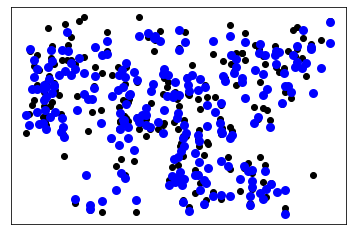

In [30]:
var =  3
plt.scatter(drought_dataset_test.X[:,-1,var], actual_y,  color='black')
plt.scatter(drought_dataset_test.X[:,-1,var], predicted_y, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()